<a href="https://colab.research.google.com/github/TanyaClementine/gru-stockprice-prediction/blob/main/GRU_STOCK_PRICES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0755 - val_loss: 0.0624
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0013 - val_loss: 0.0060
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0011 - val_loss: 0.0093
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.1304e-04 - val_loss: 0.0093
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 5.5389e-04 - val_loss: 0.0083
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 5.8043e-04 - val_loss: 0.0061
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 5.2828e-04 - val_loss: 0.0058
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.9216e-04 - val_loss: 0.0054
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4.3408e-04 - val_loss: 0.0046
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0057
Test Loss (MSE): 0.004641086328774691
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/

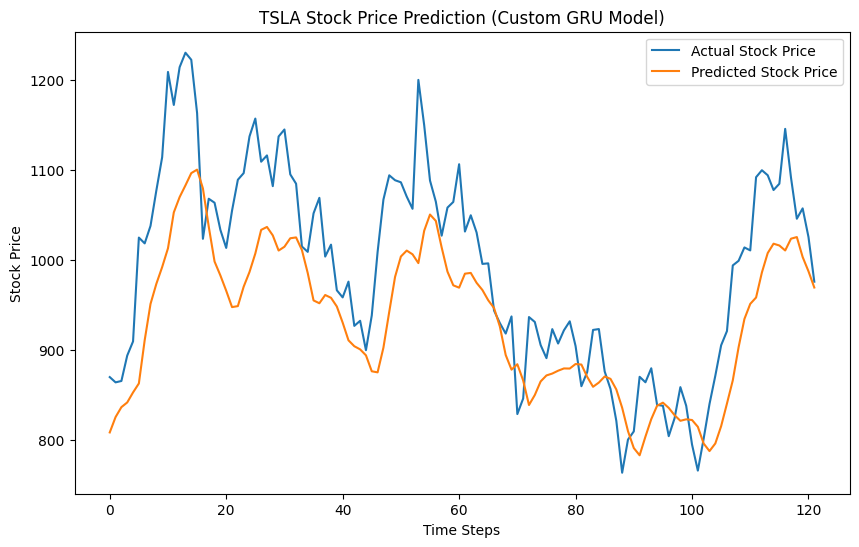

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import tensorflow as tf


# Load and preprocess the TSLA stock dataset
file_path = 'TSLA.csv'
df = pd.read_csv(file_path)



# Convert date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)


# Select features (e.g., Open, High, Low, Volume) and target (Close price)
features = df.drop(columns=['Close'])
target = df['Close']


# Normalize features and target
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))


# Function to create sequences
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)


# Prepare the sequences
SEQ_LENGTH = 30
X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH)


# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# GRU cell from scratch (same as before)
class CustomGRU(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CustomGRU, self).__init__()
        self.units = units
        self.state_size = units  # Specify the state size


    def build(self, input_shape):
        # Weights for the update gate
        self.Wz = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.Uz = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', trainable=True)
        self.bz = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)


        # Weights for the reset gate
        self.Wr = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.Ur = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', trainable=True)
        self.br = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)


        # Weights for the candidate hidden state
        self.Wh = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.Uh = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', trainable=True)
        self.bh = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)


    def call(self, inputs, states):
        h_prev = states[0]  # previous hidden state


        # Update gate
        z = tf.sigmoid(tf.matmul(inputs, self.Wz) + tf.matmul(h_prev, self.Uz) + self.bz)


        # Reset gate
        r = tf.sigmoid(tf.matmul(inputs, self.Wr) + tf.matmul(h_prev, self.Ur) + self.br)


        # Candidate hidden state
        h_hat = tf.tanh(tf.matmul(inputs, self.Wh) + tf.matmul(r * h_prev, self.Uh) + self.bh)


        # Current hidden state
        h = (1 - z) * h_prev + z * h_hat
        return h, [h]  # Return the hidden state and the new state


# Custom GRU model using the defined GRU cell
class CustomGRUModel(tf.keras.Model):
    def __init__(self, units):
        super(CustomGRUModel, self).__init__()
        self.gru1 = tf.keras.layers.RNN(CustomGRU(units), return_sequences=True)
        self.gru2 = tf.keras.layers.RNN(CustomGRU(units // 2))
        self.dense = tf.keras.layers.Dense(1)


    def call(self, inputs):
        # First GRU layer
        h1 = self.gru1(inputs)


        # Second GRU layer
        h2 = self.gru2(h1)


        # Final output layer
        output = self.dense(h2)
        return output


# Reshape X for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


# Initialize and compile the custom GRU model
model = CustomGRUModel(units=64)
model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")


# Predict and inverse transform the scaled predictions
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test_actual = scaler.inverse_transform(y_test)


# Calculate MAE for test set
mae_test = mean_absolute_error(y_test_actual, predicted)
print(f"Mean Absolute Error (Test): {mae_test}")


# Calculate MAPE for test set
mape_test = mean_absolute_percentage_error(y_test_actual, predicted)
test_accuracy = 1 - mape_test
print(f"Test Accuracy: {test_accuracy:.2%}")


# Plotting actual vs predicted stock prices for the test set
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual Stock Price')
plt.plot(predicted, label='Predicted Stock Price')
plt.title('TSLA Stock Price Prediction (Custom GRU Model)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
test_acc = history.history["val_loss"][-1]
test_accuracy = (1 - test_acc) * 100

train_acc = history.history["loss"][-1]
training_accuracy = (1 - train_acc) * 100

print(f"Test Accuracy : {test_accuracy:.2f}%")
print(f"Training Accuracy : {training_accuracy:.2f}%")



Test Accuracy : 99.54%
Training Accuracy : 99.96%
